In [1]:
# Importing dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data preprocessing
from sklearn import preprocessing

# Evaluation metrics
from sklearn.metrics import confusion_matrix, recall_score, roc_auc_score

# Classification models
from sklearn.ensemble import RandomForestClassifier

# Regression models for imputation
from sklearn.ensemble import RandomForestRegressor

# To save the final model
import _pickle as pickle

In [2]:
%matplotlib inline

In [3]:
from task1 import process_data

In [4]:
# Reading training data
clf_data = pd.read_csv("../results/processed_data/predictive_maintenance_dataset_processed.csv")

In [5]:
clf_data.head()

,unit_number,time_stamp,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,status
0,540,2016-05-01T12:00:00Z,42.0033,0.8400,High,445.00,549.11,1345.86,1123.35,3.91,...,2387.98,8075.70,9.3392,0.02,327.0,2212.0,100.00,10.59,6.4311,0
1,540,2016-05-02T12:00:00Z,10.0049,0.2513,High,489.05,604.12,1497.52,1299.13,10.52,...,2387.94,8126.65,8.5735,0.03,367.0,2319.0,100.00,28.54,17.2279,0
2,540,2016-05-03T12:00:00Z,20.0026,0.7011,High,491.19,606.99,1480.01,NaN,9.35,...,2387.97,8061.05,9.1776,0.02,364.0,2324.0,100.00,24.40,14.7659,0
3,540,2016-05-04T12:00:00Z,42.0023,0.8409,High,445.00,549.09,1346.29,1119.90,3.91,...,2387.98,8080.58,9.3504,0.02,NaN,NaN,100.00,10.74,6.2972,0
4,540,2016-05-05T12:00:00Z,25.0031,0.6200,NaN,462.54,536.18,1260.24,1038.22,7.05,...,2028.22,7866.67,10.8344,0.02,307.0,1915.0,84.93,14.34,8.5780,0


In [6]:
X = process_data(clf_data)

==== Processing operational_setting_1 ====
 	 Imputing 

==== Processing operational_setting_2 ====
 	 Imputing 

==== Processing operational_setting_3 ====
 	 Imputing 

==== Processing sensor_measurement_1 ====
 	 Imputing 

==== Processing sensor_measurement_2 ====
 	 Imputing 

==== Processing sensor_measurement_3 ====
 	 Imputing 

==== Processing sensor_measurement_4 ====
 	 Imputing 

==== Processing sensor_measurement_5 ====
 	 Imputing 

==== Processing sensor_measurement_6 ====
 	 Imputing 

==== Processing sensor_measurement_7 ====
 	 Imputing 

==== Processing sensor_measurement_8 ====
 	 Imputing 

==== Processing sensor_measurement_9 ====
 	 Imputing 

==== Processing sensor_measurement_10 ====
 	 Imputing 

==== Processing sensor_measurement_11 ====
 	 Imputing 

==== Processing sensor_measurement_12 ====
 	 Imputing 

==== Processing sensor_measurement_13 ====
 	 Imputing 

==== Processing sensor_measurement_14 ====
 	 Imputing 

==== Processing sensor_measurement_15 ==

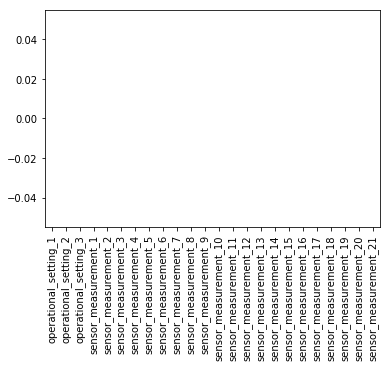

In [7]:
X.isnull().sum().plot(kind='bar')

# Retraining the best model using all the data

In [47]:
y = clf_data['status']

In [48]:
rfc_opt = RandomForestClassifier(max_depth = None, max_features = 'sqrt', n_estimators = 250)
rfc_opt.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [49]:
rfc_opt.score(X,y)

1.0

# Saving final model

In [50]:
with open('../results/pickles/task1_model.pickle', 'wb') as save_model:
    pickle.dump(rfc_opt, save_model)